**This notebook illustrates how to load and plot persistently stored clustering analyses.**

The `in_out` module provides the `save_plots_models` function that can be used to store the evaluated clustering data, the related models and to create some simple plots to gain an overview. The same module defines the `load_complete_data` function that is able to load a dataset that is stored that way, as demonstrated here. Moreover, the notebook covers some examples for extended plotting using the `visualization` module.

# Imports

Import of general packages.

In [1]:
%matplotlib inline
import os
import sys
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.axes_grid1 import ImageGrid
sns.set_context('notebook')

Import of the modules defined in the `src` module of this project.

In [3]:
# Determine the project directory and at `src` to the python path
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
project_dir = os.path.normpath(os.path.join(workbookDir, os.pardir))
sys.path.insert(0, project_dir)

from src import tools, in_out, visualize as vis

# Data Loading

In [12]:
# n_clusters settings
n_clusters_dicts = tools.defaultdict(dict)
n_clusters_dicts['Gamma-K']['TE'] = 8
n_clusters_dicts['Gamma-K']['TM'] = 8 # maybe 8
n_clusters_dicts['Gamma-M']['TE'] = 7 # maybe 8
n_clusters_dicts['Gamma-M']['TM'] = 7
n_clusters_dicts = dict(n_clusters_dicts)
    
sim_data, model_data, metadata = in_out.load_complete_data(
                                      os.path.join(project_dir, 'models'),
                                      'GaussianMixture',
                                       n_clusters_dicts)


pointlist = metadata['pointlist']
lengths = metadata['lengths']
domain_ids = metadata['domain_ids']

In [18]:
def comb_iter():
    pdict = tools.DEFAULT_SIM_PDICT
    combs = [('Gamma-K', 'TM'), ('Gamma-K', 'TE'),
             ('Gamma-M', 'TM'), ('Gamma-M', 'TE')]
    forms = [r'$\Gamma-K$, TM', r'$\Gamma-K$, TE',
             r'$\Gamma-M$, TM', r'$\Gamma-M$, TE', ]
    for i in range(4):
        yield i, combs[i][0], combs[i][1], pdict[combs[i][1]], forms[i]

### Silhouettes

From the [scikit documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

  > Silhouette analysis can be used to study the **separation distance between the resulting clusters**. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a **range of [-1, 1]**.
  >
  > Silhouette **coefficients near +1** indicate that the sample is far away from the neighboring clusters. A **value of 0** indicates that the sample is on or very close to the decision boundary between two neighboring clusters and **negative values** indicate that those samples might have been assigned to the wrong cluster.
  >
  > **Bad picks** can be identified by the presence of clusters with below average silhouette scores and by wide fluctuations in the size of the silhouette plots.
  >
  >Also from the thickness of the silhouette plot the **cluster size** can be visualized.

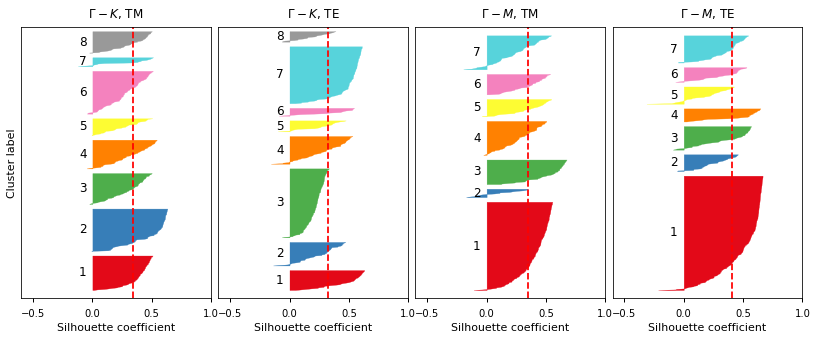

In [35]:
fig = plt.figure(figsize=(14,5))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                 nrows_ncols = (1, 4), 
                 axes_pad=0.1, # pad between axes in inch.
                 label_mode = "L",
                 cbar_mode = 'none',
                 share_all=False,
                 aspect=False)

for i, direc, pol, pol_suf, form in comb_iter():
    model = model_data[direc][pol]['model']
    sim_nums = model_data[direc][pol]['sim_nums']
    vis.plot_silhouettes(sim_data, pol_suf, sim_nums, ax=grid[i],
                         n_clusters=model.n_clusters)
    grid[i].set_title(form, y=1.01)
    grid[i].set_xlim((-0.6, 1.))
    grid[i].set_xticks(np.linspace(-0.5, 1., 4))

### Comparing fluorescence, field enhancement maps and clustering results

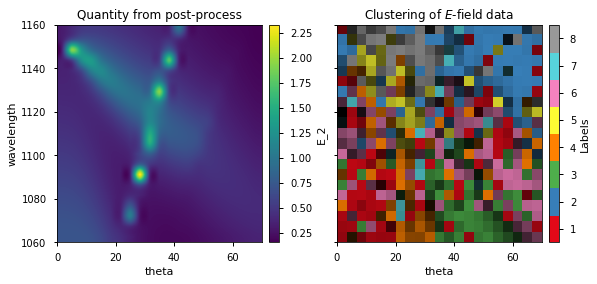

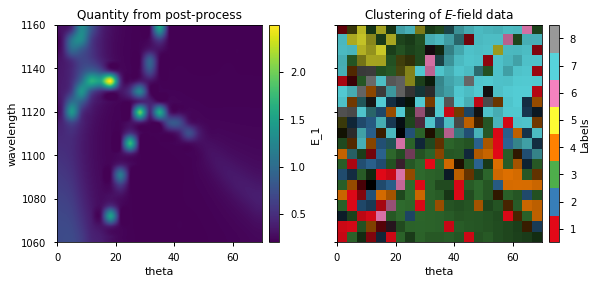

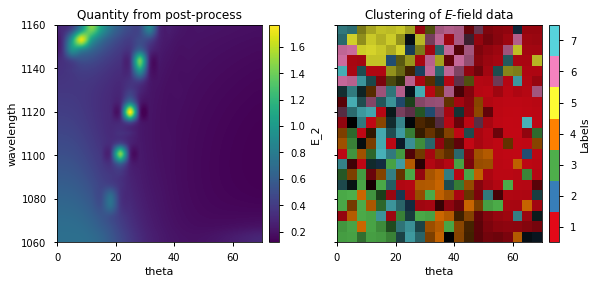

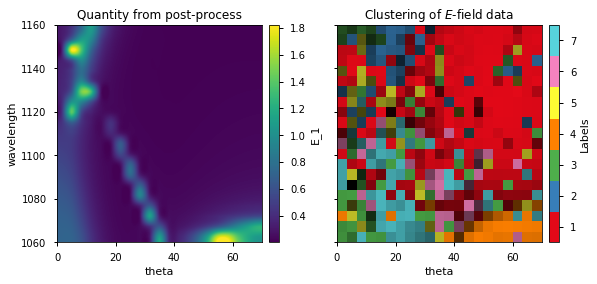

In [43]:
for i, direc, pol, pol_suf, form in comb_iter():
    model = model_data[direc][pol]['model']
    sim_nums = model_data[direc][pol]['sim_nums']
    data = sim_data.loc[sim_nums]
    vis.compare_values_and_classification(data, 'E', pol_suf,
                                          plt.figure(figsize=(9., 4.)),
                                          interpolation='spline16')

### Plotting cluster centers

In [23]:
def get_material_collections(im, plane_idx, hg_=250.e-9, hp_=116.e-9, 
                             rad_=1.835e-07):
    
    from matplotlib.patches import Polygon, Rectangle, Circle
    from matplotlib.collections import PatchCollection
    
    collections = []
    _xi, _xa, _yi, _ya = im.get_extent()
    if plane_idx < 4:
        _phcw = (_xa-_xi)/2.-rad_
        phc = [Rectangle((_xi, hg_), _phcw, hp_),
               Rectangle((_xa-_phcw, hg_), _phcw, hp_)]

        collections.append(PatchCollection(phc, facecolor=[0.8, 0.8, 0.8, 0.6], 
                                  color='white', linewidths=1.))
        glass = [Rectangle((_xi, 0.), _xa-_xi, hg_)]
        collections.append(PatchCollection(glass, 
                                    facecolor=[0.0, 0.6196078, 0.8784313, 0.6],
                                    color='white',
                                    linewidths=1.))
    else:
        dx = _xa#1./np.sqrt(3.)
        dy = _ya#0.5
        deltx = np.sqrt(dx**2-dy**2)*1.4#
        xys = [np.array([[-dx, -dy], [-dx, 0.], [-deltx, -dy]]),
               np.array([[-dx, dy], [-dx, 0.], [-deltx, dy]]),
               np.array([[dx, -dy], [dx, 0.], [deltx, -dy]]),
               np.array([[dx, dy], [dx, 0.], [deltx, dy]])]
        patches = []
        for xy in xys:
            polygon = Polygon(xy, True)
            patches.append(polygon)
        collections.append(PatchCollection(patches, facecolor='white', 
                                color='white', linewidths=1.))
        
        circle = [Circle((0.,0.), rad_)]
        collections.append(PatchCollection(circle, 
                                           facecolor=[0.,0.,0.,0.],
                                           color='white',
                                           linewidths=2.))
        
    return collections

Publication quality plot:

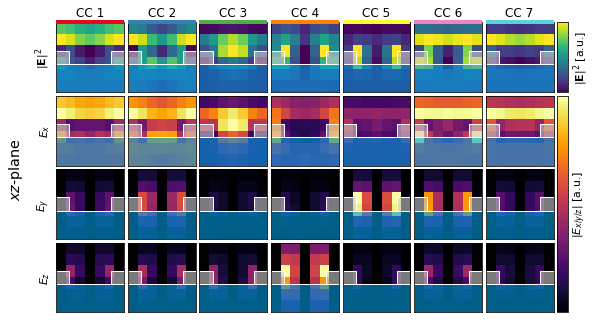

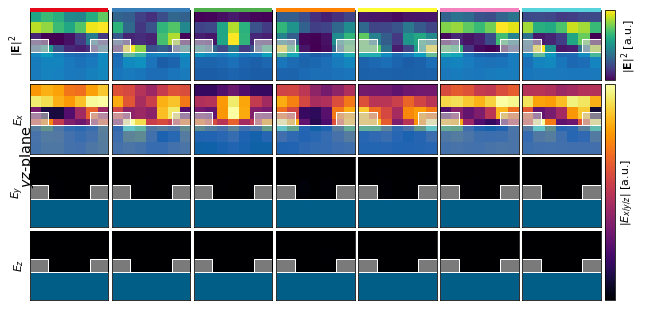

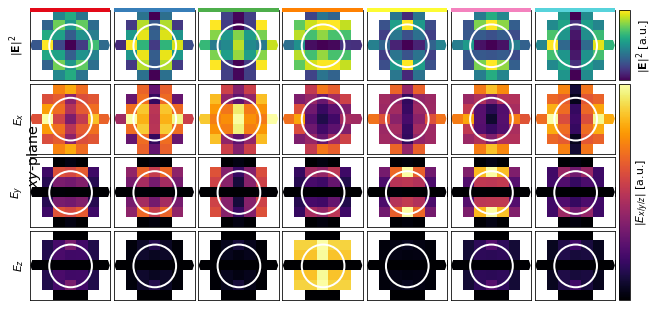

In [44]:
n_clusters = len(model.cluster_centers_)
_cmap,_,_ = vis.get_discrete_cmap(model.n_clusters)
plot_energy = True

plane_names = {0:'$xz$-plane', 3:'$yz$-plane', 4:'$xy$-plane'}
interp = 'none'

for plane_idx in [0,3,4]:

    fig = plt.figure(figsize=(2.*n_clusters, 4.*(1.+plot_energy/3.)))
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                     nrows_ncols = (3+plot_energy, n_clusters), 
                     axes_pad=0.05, # pad between axes in inch.
                     label_mode = "L",
                     cbar_mode = 'none',
                     aspect='equal')

    for icl, mcc in enumerate(model.cluster_centers_):
        dups = vis.DataOnPlanes(mcc, pointlist, lengths, domain_ids, name='H')
        plane = dups.planes[plane_idx]
        vmin, vmax = (plane.field.min(), plane.field.max())
        for i, comp in enumerate(plot_energy*['energy']+['x', 'y', 'z']):
            _ax = grid[icl+n_clusters*i]
            if comp == 'energy':
                _, im2 = plane.imshow(comp, ax=_ax,
                                      interpolation=interp)
                if icl == 0:
                    _ax.set_ylabel('$\|\mathbf{E}\|^2$')
            else:
                _, im = plane.imshow(comp, ax=_ax, vmin=vmin, vmax=vmax,
                                     interpolation=interp)
                if icl == 0:
                    _ax.set_ylabel('$E_{}$'.format(['x', 'y', 'z'][i-1]))
            _ax.set_xticks(()); _ax.set_yticks(())
            if i == 0:
                if plane_idx == 0:
                    _ax.set_title('CC {}'.format(icl+1))
                _ax.spines['top'].set_linewidth(4)
                _ax.spines['top'].set_color(_cmap.colors[icl])
                _ax.spines['top'].set_capstyle('butt')
            
            for mcol in get_material_collections(im2, plane_idx):
                _ax.add_collection(mcol)
                
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    caxe = inset_axes(grid[n_clusters-1], 0.15, "100%", loc=3, 
                      bbox_to_anchor=(1.05,0,1,1), 
                      bbox_transform=grid[n_clusters-1].transAxes,
                      borderpad=0.0)
    cbe = plt.colorbar(im2, cax=caxe)
    cbe.set_ticks(())
    caxe.set_ylabel(r'$\|\mathbf{E}\|^2$ [a.u.]')
    
    cax = inset_axes(grid[-1], 0.15, "310%", loc=3,
                     bbox_to_anchor=(1.05,0,1,1), 
                     bbox_transform=grid[-1].transAxes, borderpad=0.0)
    cb = plt.colorbar(im, cax=cax)
    cb.set_ticks(())
    cax.set_ylabel(r'$|E_{x/y/z}|$ [a.u.]')
    
    plt.suptitle(plane_names[plane_idx], rotation='vertical', x=0.235, y=0.5,
                 verticalalignment='center', horizontalalignment='right')
    plt.show()